# LVM Data Simulator tutorial: exposure time calculator

## Setting up the ETC

This simulator can be easily used to estimate the required LVM exposure time to obtain a certain signal-to-noise ratio (S/N) for a simple source configuration. It simulates only the central fiber of the array, and provide plots showing how the S/N changes as a function of exposure time. For complex scenarios, a full simulation should be run following instructions on the other tutorials.

This ETC will simulate only nebulae with:
- uniform brightness distribution
- constant emission line ratios (defined by one of the pre-computed Cloudy models)
- or/and constant level and shape of the continuum.
On top of this a star with particular properties also can be part of the object under evaluation. Nebular component, continuum from the object and the stellar spectrum will be combined together by the simulator in a single fiber, for which we will run the calculations.

**N.B.: the resulting S/N ratio is the value measured per spectral pixel (0.5A) in the output spectra at a particular wavelength. This simplified ETC doesn't integrate the emission lines and do not subtract the underlying continuum but rather estimate the S/N in the pixel at the center of the line.**

**N.B.2: All calculations are performed assuming a single exposure.**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from lvmdatasimulator.run import run_lvm_etc

The first step is to define the parameters of your nebula. The only required parameter is 'max_brightness' (in erg/s/cm\^2/arcsec^2).
See [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb) if you want to learm how to specify the spectral properties (emission and continuum) of the nebula.

In [2]:
ha_brightness = 1.5e-15 # based on MCELS image

In [3]:
neb_params = {'max_brightness': ha_brightness, 'model_id': 'Shell_205', 'model_type': 'cloudy'}

Also you may define parameters of the star if you want to put it in the fiber. It should be a dictionary containing the magnitude and temperature of the desired star, as follows:

In [4]:
# currently ignored
star_params = {'gmag': [10], 'teff': [10000]}

Other parameters can be passed to the simulator in general (see [tutorial #3](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial3.ipynb)), but only these two should be used when running the ETC. Also note that the parameters must be provided as lists.

The dictionary below (``params``) is the main input for the ETC. It joins together the parameters of the nebula and the star, and also can contain parameters defining the observations (see [tutorial 2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb)). Note that ``exptimes`` is not used as it is hardcoded in the ETC. As a default, the simulation is run at an airmass of 1.5 and in dark conditions (0 days from new moon). These conditions can be adjusted by providing the ``airmass`` and ``days_moon`` parameters in the ``params`` dictionary, as shown below. It is also possible to provide a custoim sky spectrum via the ``sky_template`` parameter, as described in [tutorial 2](https://github.com/sdss/lvmdatasimulator/blob/main/examples/LVM_data_simulator_tutorial2.ipynb). 

Other three parameters are required to run the ETC:
- ``check_lines`` - list of the lines (wavelength in A, float) for which ETC will check the dependence of the S/N on the exposure time.
- ``desired_snr`` - if provided, then ETC will print (and return) the required exposures to reach the target S/N at the respective wavelength.
- ``continuum`` - bool (default is False). It defines how the S/N ratio will be calculated. If it is true, then the code assumes we are interested in the S/N in the continuum rather then in emission lines - then the S/N per spectral pixel will be considered. Otherwise, the code assumes the measurements in emission lines, and thus the S/N is measured by integrating the signal and estimating the noise in the ±2A aperture around the wavelengths in ``check_lines``.
- ``delete`` - bool (default is True). If this parameter is set to True, all the files produced during the simulations will be deleted. If you want to keep all the output, please set ``delete`` to False.


In [5]:
params = {'name': 'AV435etc',
          'nebula': neb_params,
          'airmass': 1.6,
          'days_moon': 7,
          }

[INFO]: Start simulations in exposure time calculator mode for 1 nebula 
[INFO]: Start generating 1 nebulae
[INFO]: Generated ISM saved to ./AV435etc/test.fits
[INFO]: ISM content saved to test.fits
[INFO]: Using only the central fiber.
[INFO]: Simulating observations.
[INFO]: Reading the atmospheric extinction from file.
[INFO]: Resample extinction file to instrument wavelength solution.
[INFO]: Simulating the sky emission 7 days from new moon.
[INFO]: Using sky file: /Users/tonywong/Library/Python/3.9/lib/python/data/sky/LVM_LVM160_SKY_7.dat
[INFO]: Resample sky emission to instrument wavelength solution.
[INFO]: Recovering target spectra for 1 fibers.
[INFO]: Start extracting nebular spectra
[INFO]: Resampling spectra to the instrument wavelength solution.
[INFO]: Saving the outputs:
[INFO]: Input spectra
[INFO]: ./AV435etc/outputs/AV435etc_linear_central_input.fits saved.
[INFO]: Clean outputs
[INFO]: ./AV435etc/outputs/AV435etc_linear_central_10_no_noise.fits saved.
[INFO]: ./AV43

To reach S/N=100 in line = 6563±1A we need 403s of single exposure
To reach S/N=30 in line = 4959±1A we need 239s of single exposure
To reach S/N=30 in line = 6716±1A we need 693s of single exposure
To reach S/N=3 in line = 4363±1A we need 1688s of single exposure


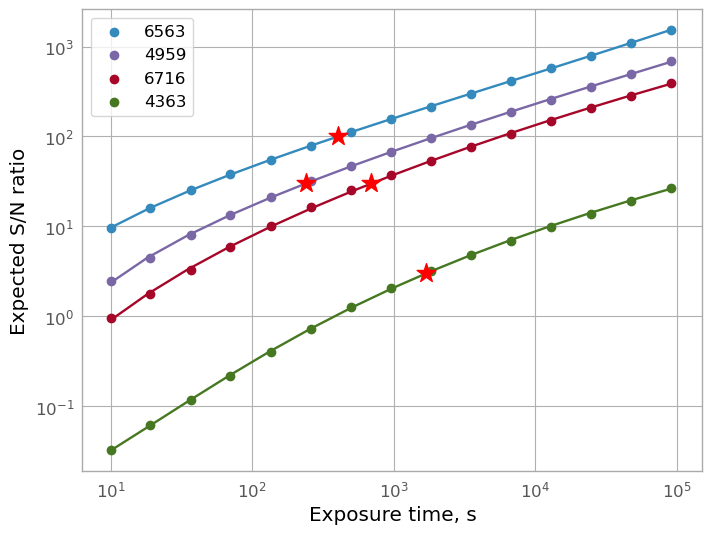


Elapsed time: 4.2s


[403, 239, 693, 1688]

In [6]:
run_lvm_etc(params, check_lines=[6563,4959,6716,4363], desired_snr=[100,30,30,3], continuum=False, 
            delete=False, saveplot='snr_etc.png')

In [7]:
src = params['name']
print(src)

AV435etc


In [8]:
def plot_spec(xfits=None,wmin=3800,wmax=7200):
    x=fits.open(xfits)
    w=x['WAVE'].data
    flux=x['TARGET'].data[0]
    total=x['TOTAL'].data[0]
    err=x['ERR'].data[0]
    
    select=[]
    i=0
    while i<len(w):
        if wmin<=w[i] and w[i]<=wmax:
            select.append(i)
        i+=1
    w=w[select]
    flux=flux[select]
    total=total[select]
    err=err[select]
    
    plt.plot(w,flux,label='target')
    # plt.plot(w,total,label='total',alpha=0.8)
    plt.plot(w,err-0.5e-13,label='error',alpha=0.8)
    plt.legend()
    plt.xlim(wmin,wmax)
    ymax=2*np.max(flux)
    ymin=-0.1*ymax
    plt.ylim(ymin,ymax)
    # plt.ylim(-1e-13,3e-13)
    plt.xlabel(r'Wavelength ($\AA$)',size=16)
    plt.ylabel(r'Flux (ergs cm$^{-2}$ s$^{-1}$ $\AA^{-1}$ spaxel$^{-1}$)',size=16)
    #plt.savefig('snr.png')

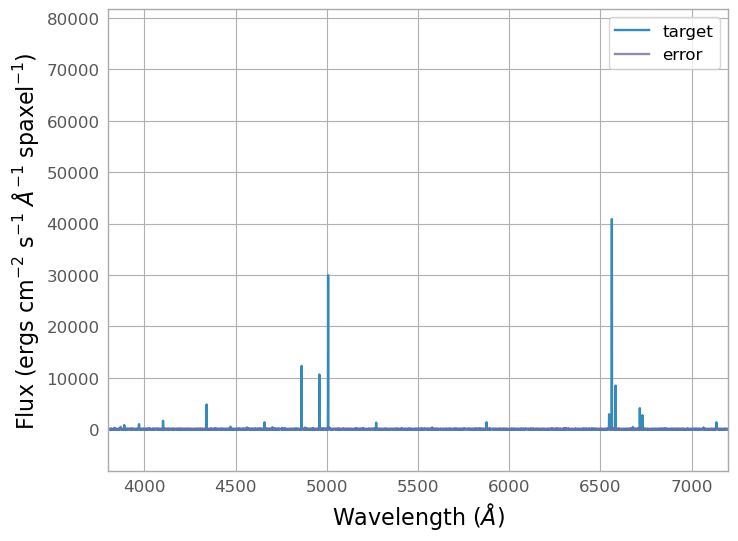

In [9]:
plot_spec(xfits=f'{src}/outputs/{src}_linear_central_3483_realization.fits', wmin=3800,wmax=7200)

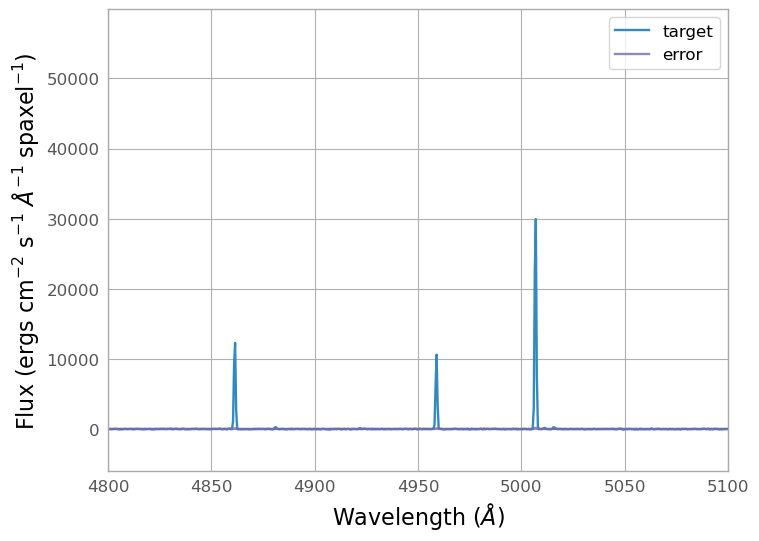

In [10]:
plot_spec(xfits=f'{src}/outputs/{src}_linear_central_3483_realization.fits', wmin=4800,wmax=5100)

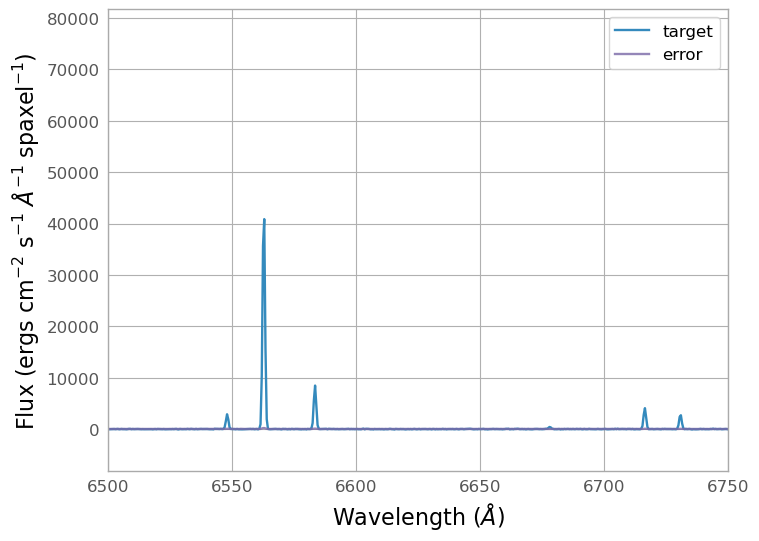

In [11]:
plot_spec(xfits=f'{src}/outputs/{src}_linear_central_3483_realization.fits', wmin=6500,wmax=6750)